In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle

In [2]:
rng = np.random.RandomState(42)

In [3]:
signal, labels = make_blobs(n_samples=int(1e5), n_features=2,
                            cluster_std=.1, centers=500,
                            random_state=rng)
noise = rng.uniform(low=-15, high=15, size=(len(signal) // 10, 2))

data = np.vstack([signal, noise])
labels = np.concatenate([labels, [-1] * noise.shape[0]])
data, labels = shuffle(data, labels, random_state=rng)

In [4]:
def plot_data_with_labels(data, labels, alpha=0.3, cm=plt.cm.prism, subsample=int(5e4),
                          random_state=0):
    n_samples = data.shape[0]
    if n_samples > subsample:
        idx = shuffle(np.arange(n_samples), random_state=random_state)[:subsample]
        data = data[idx]
        labels = labels[idx]

    plt.figure(figsize=(10, 10))
    plt.xlim(-12, 12)
    plt.ylim(-12, 12)

    unique_labels = np.unique(labels)
    colors = cm(np.linspace(0, 1, len(unique_labels)))
    for l, c in zip(unique_labels, colors):
        if l == -1:
            c = 'b'
        data_l = data[labels == l]
        plt.scatter(data_l[:, 0], data_l[:, 1], alpha=alpha,
                    facecolors=c, edgecolors='none')

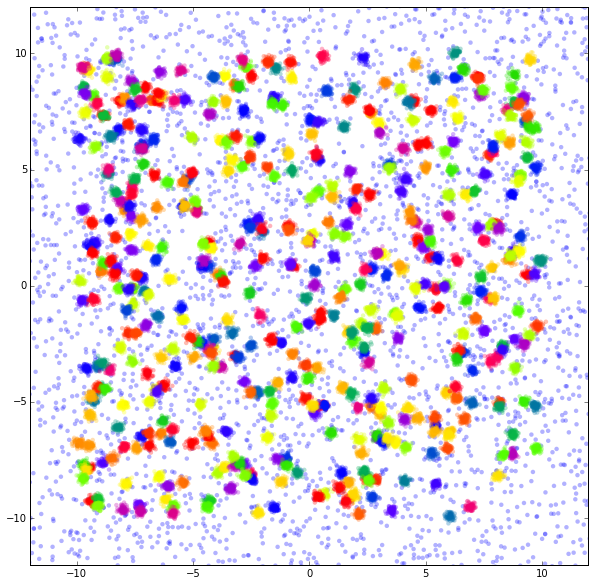

In [5]:
plot_data_with_labels(data, labels)

## DBSCAN

In [6]:
%%time
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, algorithm='kd_tree')
dbscan_labels = dbscan.fit_predict(data)

CPU times: user 9.03 s, sys: 109 ms, total: 9.14 s
Wall time: 9.04 s


In [7]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

print("NMI DBSCAN: %0.3f"
      % normalized_mutual_info_score(labels, dbscan_labels))
print("ARI DBSCAN: %0.3f"
      % adjusted_rand_score(labels, dbscan_labels))

NMI DBSCAN: 0.877
ARI DBSCAN: 0.453


In [8]:
unique_dbscan_labels = np.unique(dbscan_labels)
print(len(unique_dbscan_labels))

415


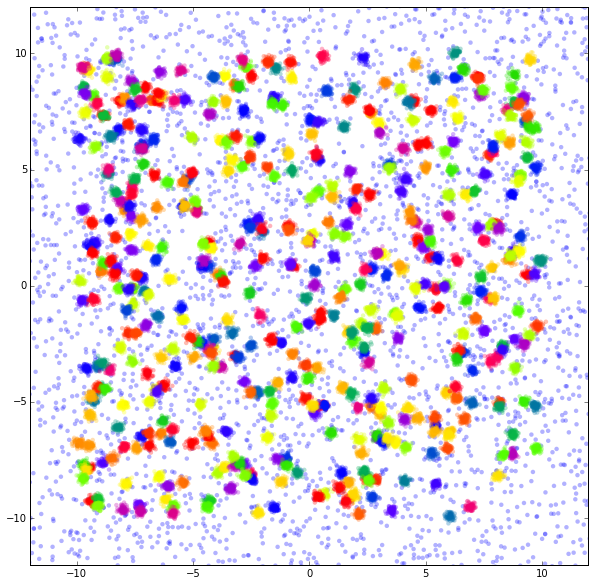

In [9]:
plot_data_with_labels(data, labels)

##  Mini Batch K-Means

In [10]:
%%time
from sklearn.cluster import MiniBatchKMeans

mbkmeans = MiniBatchKMeans(n_clusters=500, init_size=int(1e4), batch_size=int(1e3))
mbkmeans_labels = mbkmeans.fit_predict(data)

CPU times: user 4.5 s, sys: 2.52 s, total: 7.03 s
Wall time: 4.23 s


In [11]:
print("NMI MB K-Means: %0.3f"
      % normalized_mutual_info_score(labels, mbkmeans_labels))
print("ARI MB K-Means: %0.3f"
      % adjusted_rand_score(labels, mbkmeans_labels))

NMI MB K-Means: 0.897
ARI MB K-Means: 0.245


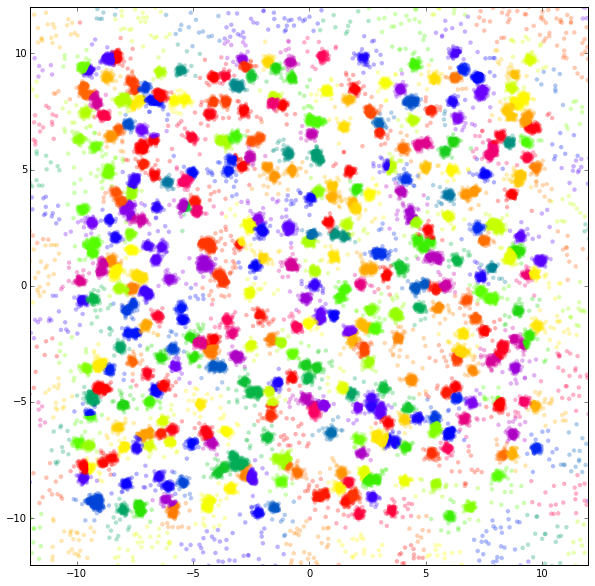

In [12]:
plot_data_with_labels(data, mbkmeans_labels)

## Birch

In [13]:
%%time
from sklearn.cluster import Birch

birch = Birch(threshold=0.5, n_clusters=500)
birch_labels = birch.fit_predict(data)

CPU times: user 17.1 s, sys: 1min 14s, total: 1min 31s
Wall time: 9.35 s


In [23]:
print("NMI Birch: %0.3f"
      % normalized_mutual_info_score(labels, birch_labels))
print("ARI Birch: %0.3f"
      % adjusted_rand_score(labels, birch_labels))

NMI Birch: 0.838
ARI Birch: 0.193


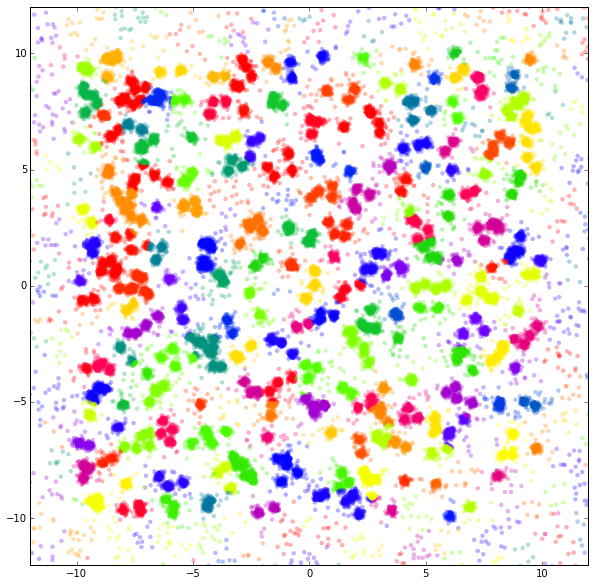

In [15]:
plot_data_with_labels(data, birch_labels)

In [16]:
print(len(birch.subcluster_centers_))

1029


In [17]:
%%time
birch.set_params(n_clusters=10)
birch.partial_fit()

CPU times: user 634 ms, sys: 2.1 ms, total: 637 ms
Wall time: 634 ms


In [18]:
%%time
birch_labels_small = birch.predict(data)

CPU times: user 868 ms, sys: 161 ms, total: 1.03 s
Wall time: 1.03 s


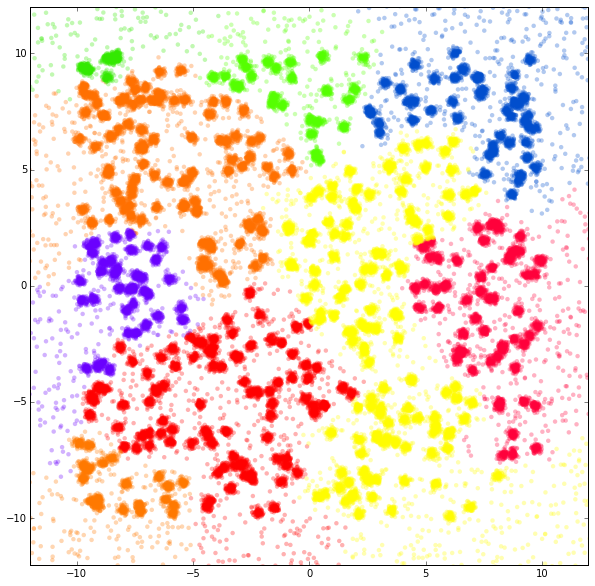

In [19]:
plot_data_with_labels(data, birch_labels_small)

## Batch K-Means

In [20]:
# %%time
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=500, n_jobs=10)
# kmeans_labels = kmeans.fit_predict(data)

In [21]:
# print("NMI K-Means: %0.3f"
#       % normalized_mutual_info_score(labels, kmeans_labels))
# print("ARI  K-Means: %0.3f"
#       % adjusted_rand_score(labels, kmeans_labels))

In [22]:
# plot_data_with_labels(data, kmeans_labels)